adjacency values:
- similar: big
- dissimilar: small

In [1]:
import difflib
import geopandas as gpd
from geopy.distance import distance as geopydist
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from os import path
import pandas as pd
import pickle as pkl
from pyproj import CRS
from scipy.spatial import distance as scipydist
from shapely.geometry import Polygon, Point, GeometryCollection, LineString
from shapely import geometry, ops

from setup import *

In [2]:
# Read CTA Rail Lines
l = gpd.read_file(data_dir+"data_raw/CTA_Rail/CTA_rail_line.shp") 
if l.crs != "epsg:26916":
    l = l.to_crs("epsg:26916")
    l.to_file(data_dir+"data_raw/CTA_Rail/CTA_rail_line.shp") 
    
lines = nx.read_shp(data_dir+"data_raw/CTA_Rail/CTA_rail_line.shp") 

<ipython-input-2-50c255e7372a>:7: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  lines = nx.read_shp(data_dir+"data_raw/CTA_Rail/CTA_rail_line.shp")


In [3]:
# Read CTA Rail Stations
s = gpd.read_file(data_dir+"data_raw/CTA_Rail/CTA_RailStations.shp") 
s = s.to_crs("epsg:26916")

## Process discrepancies between real lines and shp representation
- Directly connect the edges that are predecessors and successors of the connectors
- Delete the connectors
- Delete the nodes that are not in ventra

In [6]:
# read in ridership data
rail = pd.read_csv(data_dir+"data_processed/rail_catchment/rail_df_200316_201031.csv")
rail_los = pd.read_csv(data_dir+"data_processed/rail_catchment/raillos_df_200316_201031.csv")
df = pd.merge(rail, rail_los, how='inner', left_on=['ts','station_id'], right_on=['ts','station_id'])

stations_with_counts = df['station_id'].drop_duplicates()

lookup = pd.read_csv(data_dir+"ventra_gtfs_match.csv")
stations_with_counts = pd.merge(stations_with_counts, lookup, on='station_id')['station_id'].to_numpy()


In [7]:
num_nodes = len(list(lines.nodes))

# Get the STATION_ID of the nodes in the lines shapefile
# fill in -1 if the node is a connection in the shapefile but not an actual station
station_ids = []
new_edges = []
to_remove = []
station_coord = {}
for n in list(lines.nodes):
    dist = [scipydist.euclidean(n,ns) for ns in zip(s.geometry.x, s.geometry.y)]
    min_dist = np.argmin(dist)
    if (np.min(dist) > 15) | (s.iloc[min_dist]['STATION_ID'] not in stations_with_counts):
        predecessors = lines.predecessors(n)
        successors = lines.successors(n)
        new_edges += [(p,s,{'SHAPE_LEN':scipydist.euclidean(p,s)}) for p in predecessors for s in successors]
        to_remove.append(n)
    else:
        station_ids.append(s.iloc[min_dist]['STATION_ID'])
        station_coord[str(n)] = s.iloc[min_dist]['STATION_ID']
print("Number of Stations:", sum(np.array(station_ids)>0))

lines.add_edges_from(new_edges)
lines.remove_nodes_from(to_remove)
station_ids = np.array(station_ids)

Number of Stations: 142


## 1. Adjacency based on Euclidean distance
 - between every pair of nodes
 - unit: km

In [15]:
start_node = []
end_node = []
start_id = []
end_id = []
euc_dist = []
# stations within 500m are treated as 1 (connected)
# the rest decays with distance
th = 500

for n1 in list (lines.nodes):
    for n2 in list(lines.nodes):
        start_node.append(str(n1))
        start_id.append(station_coord[str(n1)])
        end_node.append(str(n2))
        end_id.append(station_coord[str(n2)])
        if n1==n2:
            euc_dist.append(0)
        else:
            d = scipydist.euclidean(n1,n2)
            if d < th:
                euc_dist.append(1)
            else:
                euc_dist.append(th/d)  

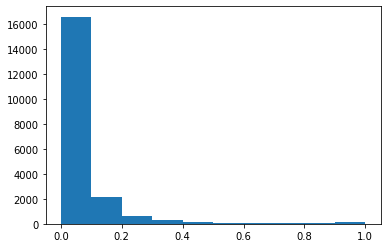

In [8]:
plt.hist(euc_dist);

In [30]:
adjlist = pd.DataFrame(np.array([start_node,start_id,end_node,end_id,euc_dist]).T, 
                       columns = ['start_node','start_id','end_node','end_id','euc_dist'])

In [31]:
adjlist['start_id'] = adjlist['start_id'].astype(int)
adjlist['end_id'] = adjlist['end_id'].astype(int)

## 2. Adjacency based on connectivity

In [12]:
start_node = []
end_node = []
start_id = []
end_id = []
distance = []
th = 500

for temp in nx.generate_adjlist(lines):
    for n in temp.split(") (")[1:]:
        start_node.append(temp.split(") (")[0]+")")
        if n[-1] != ')':
            n = n + ')'
        if n[0] != '(':
            n = '(' + n
        end_node.append(n)
        start_id.append(int(station_coord[temp.split(") (")[0]+")"]))
        end_id.append(int(station_coord[n]))
        d = lines[eval(start_node[-1])][eval(end_node[-1])]['SHAPE_LEN']/1000
        distance.append(d)

        # add the other direction
        distance.append(d)
        end_node.append(temp.split(") (")[0]+")")
        start_node.append(n)
        end_id.append(int(station_coord[temp.split(") (")[0]+")"]))
        start_id.append(int(station_coord[n]))

In [13]:
conn = pd.DataFrame(np.array([start_id,end_id,distance]).T, 
                       columns = ['start_id','end_id','edge_len'])
conn['conn'] = 1
conn.drop_duplicates(inplace=True)

In [14]:
adjlist = pd.merge(adjlist, conn, on=['start_id','end_id'], how='outer').fillna(0)

## 3. Adjacency based on Network Distance


In [15]:
length = nx.all_pairs_dijkstra_path_length(lines, weight='SHAPE_LEN')

th = 1000
start_node = []
end_node = []
network_distance = []
start_id = []
end_id = []
for temp in length:
    for n in temp[1].keys():
        if temp[0] == n:
            continue
        start_node.append(str(temp[0]))
        end_node.append(str(n))
        start_id.append(station_coord[str(temp[0])])
        end_id.append(station_coord[str(n)])

        d = temp[1][n]
        if start_id == end_id:
            d = 0
        elif d < th:
            d = 1
        else:
            d = th / temp[1][n]
        
        network_distance.append(d)
        
# add the other direction
temp = start_node.copy()
start_node = start_node + end_node
end_node = end_node + temp
network_distance = network_distance + network_distance
temp = start_id.copy()
start_id = start_id + end_id
end_id = end_id + temp

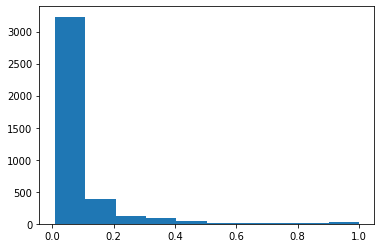

In [16]:
plt.hist(network_distance);

In [17]:
network = pd.DataFrame(np.array([start_id, end_id, network_distance]).T, 
                       columns = ['start_id','end_id','network_dist'])
network.drop_duplicates(subset=['start_id','end_id'], inplace=True)
adjlist = pd.merge(adjlist, network, on=['start_id','end_id'], how='outer').fillna(0)

## 4. Functional Similarity

In [29]:
spatial = pd.read_csv(data_dir+"data_processed/rail_catchment/spatial.csv")
spatial['pct_adults'] = spatial['pct25_34yrs']+spatial['pct35_50yrs']
spatial = spatial[spatial['STATION_ID'].isin(station_ids)]
n = len(spatial)

In [30]:
for i in ['tot_population', 'jobs', 'avg_tt_to_work','inc_per_capita',
         'entertainment', 'restaurant', 'school', 'shop']:
    spatial.loc[:,i] = spatial[i]/spatial[i].max()

In [31]:
ids=spatial['STATION_ID'].astype(int).to_numpy()
i1 = np.transpose(np.tile(ids, (n,1)), (1,0)).flatten()
i2 = np.tile(ids, (n,1)).flatten()

In [32]:
s = spatial[['tot_population','pct_adults','pctover65yrs',
         'pctwhite_alone', 'jobs', 
         'pctPTcommute','avg_tt_to_work','inc_per_capita',
         'entertainment', 'restaurant', 'school', 'shop']]

In [34]:
s1 = np.transpose(np.tile(s, (n,1,1)),(1,0,2))
s2 = np.tile(s, (n,1,1))
s3 = np.sum(np.sqrt((s1-s2)*(s1-s2)), axis=2)

In [35]:
s4 = s3[(s3 > 0)].min()/s3
s4 = s4.flatten()
s4[~np.isfinite(s4)] = 0

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [43]:
func = pd.DataFrame(np.array([i1,i2,s4]).T, columns=['start_id','end_id','func_sim'])
adjlist = pd.merge(adjlist, func, on=['start_id','end_id'], how='outer').fillna(0)

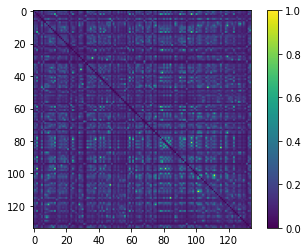

In [42]:
plt.imshow(func.pivot('start_id','end_id','func_sim').to_numpy())
plt.colorbar();

## Visualize Downtown Stations

In [44]:
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")

In [45]:
adjlist_dt = adjlist[(adjlist['start_id'].isin(downtown_stations['STATION_ID'])) & \
                     (adjlist['end_id'].isin(downtown_stations['STATION_ID']))]

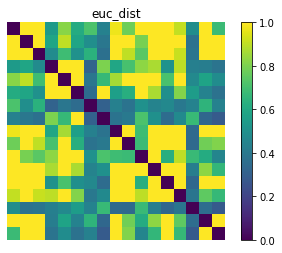

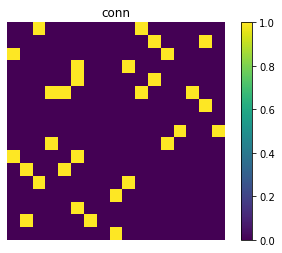

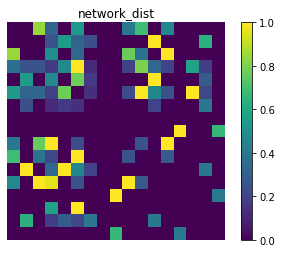

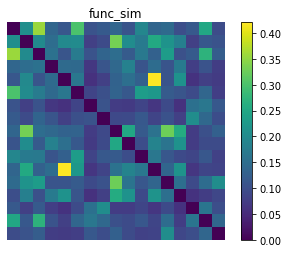

In [46]:
pivot = adjlist_dt.pivot(index='start_id',columns='end_id')
for c in ['euc_dist','conn','network_dist','func_sim']:
    plt.figure()
    plt.imshow(pivot[c].to_numpy(dtype=np.float)[:-1,:-1])
    plt.axis('off')
    plt.title(c)
    plt.colorbar()


## EXPORT

In [47]:
adjlist.to_csv(data_dir+"data_processed/rail_catchment/other/rail_adjlist.csv", index=False)